In [1]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"
urllib.request.urlretrieve(url, "./fr.openfoodfacts.org.products.csv.zip")

('./fr.openfoodfacts.org.products.csv.zip',
 <http.client.HTTPMessage at 0x278f2aded20>)

In [2]:
with zipfile.ZipFile("./fr.openfoodfacts.org.products.csv.zip", 'r') as zipRef:
    with zipRef.open('fr.openfoodfacts.org.products.csv') as file:
        data = pd.read_csv(file, sep="\t", low_memory=False)

Divide output in 2, All metadata and qualitative first, the nutri data in second

In [3]:
varList = data.columns.tolist()
print(varList)
sizeData = data.shape[0]
startNut = varList.index("energy_100g")
missingRate = data.iloc[:, :startNut].isnull().sum()/sizeData
missingRateNut = data.iloc[:, startNut:].isnull().sum()/sizeData
pd.set_option('display.max_rows', None)
print(missingRate[missingRate < 0.50])
print(missingRateNut[missingRateNut < 0.50])

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

nutrition_grade_fr will be my principal feature, the target of the db is this feature, it's qualitative and with 69% not Nan in the file


'energy_100g',
'fat_100g',
'saturated-fat_100g', 
'sugars_100g' ,
'salt_100g', 
'sodium_100g',
'fiber_100g',
'proteins_100g',
'fruits-vegetables-nuts_100g'
I want to keep these features for the main feature nutrition_grade_fr because they are connected to it. they are main variables of the calculation of nutrition-score-fr_100g wich is use with categorie to give a nutrition_grade_fr letter

In [4]:
def prepareData(data, targetColumn, subsetDup, keep, filter):
    if targetColumn not in data.columns:
        raise ValueError(f"{targetColumn} is not in dataFrame.")
    dataCleaned = data.dropna(subset=[targetColumn]).copy()
    if subsetDup:
        dataCleaned = dataCleaned.drop_duplicates(subset=subsetDup)
    else:
        print("No target for subsetDup.")
        
    if 'countries_tags' in dataCleaned.columns:
        dataCleaned['countries_tags'] = dataCleaned['countries_tags'].fillna('')
        dataCleaned = dataCleaned[dataCleaned['countries_tags'].str.contains('en:france')]
    dataCleaned = dataCleaned[keep]
    y = dataCleaned[targetColumn]
    X = dataCleaned
    
    
    return X, y

In [5]:
def createBarplot(ax, data, col):
    valueCounts = data[col].value_counts().sort_index()
    sns.barplot(x=valueCounts.index, y=valueCounts.values, ax=ax)
    ax.set_title(f'Count of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    

def plotBarplots(data, columns):
    numCols = len(columns)
    
    fig, axes = plt.subplots(numCols, 1, figsize=(15, 5 * numCols))
    axes = np.array(axes).flatten()
    
    list(map(createBarplot, axes[:numCols], [data]*numCols, columns))
    
    plt.show()

In [6]:
def createBoxplot(ax, data, col):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Distribution of {col}')

def plotBoxplots(data, columns):
    numCols = len(columns)
    numRows = numCols // 3 + (numCols % 3 > 0)
    
    fig, axes = plt.subplots(numRows, 3, figsize=(15, 5 * numRows))
    axes = np.array(axes).flatten()
    
    list(map(createBoxplot, axes[:numCols], [data]*numCols, columns))
    
    plt.tight_layout()
    plt.show()

In [7]:
def createSubplot(ax, data, col):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    
def plotHistograms(data, columns):
    numCols = len(columns)
    numRows = numCols // 3 + (numCols % 3 > 0)
    
    fig, axes = plt.subplots(numRows, 3, figsize=(15, 5 * numRows))
    axes = np.array(axes).flatten()
    
    list(map(createSubplot, axes[:numCols], [data]*numCols, columns))
    
    plt.tight_layout()
    plt.show()   


In [8]:
def checkConvert(value, minVal, maxVal, scale):
    if value < minVal or value > maxVal:
        converted_value = value / scale
        if minVal <= converted_value <= maxVal:
            return converted_value
    return value
            
def treatOutliers(data, thresholds):
    dataClean = data.copy()
    for col, (minVal, maxVal) in thresholds.items():
        if col in data.columns:
            if col != 'energy_100g':
                dataClean[col] = dataClean[col].apply(lambda x: checkConvert(x, minVal, maxVal, 1000))
            dataClean.loc[dataClean[col] < minVal, col] = minVal
            dataClean.loc[dataClean[col] > maxVal, col] = maxVal
    
    return dataClean

In [9]:
def missingVar(data):
	missing_percentages = (data.isnull().mean() * 100).sort_values(ascending=False)
	plt.figure(figsize=(12, 6))
	missing_percentages.plot(kind='bar')
	plt.title('Missing %')
	plt.xlabel('columns')
	plt.ylabel('% missing')
	plt.xticks(rotation=90)
	plt.tight_layout()
	plt.show()

In [10]:
def imputeMissingValues(data):
    dataImputed = data.copy()
    
    numericColumns = data.select_dtypes(include=[np.number]).columns
    for col in numericColumns:
        if col != "fiber_100g" and col != "proteins_100g" and col != "fruits-vegetables-nuts_100g":
            dataImputed[col] = dataImputed[col].fillna(dataImputed[col].median())
        else:
            dataImputed[col] = dataImputed[col].fillna(0)
            
    missingPercentages = (dataImputed.isnull().mean() * 100).sort_values(ascending=False)
    print(missingPercentages)
    return dataImputed

In [11]:
def plotpairplots(data, col):
	sns.set_theme(style="ticks")
	sns.pairplot(data[col], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
	plt.tight_layout()
	plt.show()


In [12]:

def createBoxplotSubplot(x, ax, var, data, y, order):
    sns.boxplot(x=x, y=var, data=pd.concat([data, y], axis=1), ax=ax, order=order)
    ax.set_title(f'{var} per nutri grade')

def multiBoxPlots(x, data, y, numericColumns):
    numCols = len(numericColumns)
    data = data.drop(x, axis=1)
    fig, axes = plt.subplots(numCols, 1, figsize=(15, 40))
    order = ['a', 'b', 'c', 'd', 'e']
    list(map(createBoxplotSubplot, [x] * numCols, axes, numericColumns, [data] * numCols, [y] * numCols, [order] * numCols))
    plt.tight_layout()
    plt.show()



In [13]:
def corrplot(data, y, col, yNumeric):
	dataCombined = pd.concat([data[col], yNumeric], axis=1)
	correlations = dataCombined[col + [yNumeric.name]].corr()[yNumeric.name].sort_values(ascending=False)
	plt.figure(figsize=(12, 8))
	sns.barplot(x=correlations.index, y=correlations.values)
	plt.title('Correlation with nutri grade')
	plt.xticks(rotation=45, ha='right')
	plt.ylabel('Correlation coefficient')
	plt.show()

In [14]:
def heatplot(data, col):
    plt.figure(figsize=(12, 10))
    sns.heatmap(data[col].corr(), 
                annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation heatmap')
    plt.show()

In [19]:
def plotScaler(data, col, categories=None):
    scaler = StandardScaler()
    XScaled = scaler.fit_transform(data[col])

    pca = PCA()
    XPca = pca.fit_transform(XScaled)

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    ax[0, 0].plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
    ax[0, 0].set_xlabel('Number of components')
    ax[0, 0].set_ylabel('Cumulative explained variance')
    ax[0, 0].set_title('Scree Plot')

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    print(f'Cumulative variance ratio for 2 components: {cumulative_variance_ratio[1]*100:.2f}%')

    feature_names = data[col].columns
    if len(feature_names) > 2:
        for i in range(len(feature_names)):
            ax[0, 1].arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                           head_width=0.05, head_length=0.05, color='blue')
    
        for i, feature in enumerate(feature_names):
            ax[0, 1].text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, feature,
                          color='black', ha='center', va='center')
    
        ax[0, 1].set_xlim(-1, 1)
        ax[0, 1].set_ylim(-1, 1)
        ax[0, 1].set_xlabel('Principal Component 1')
        ax[0, 1].set_ylabel('Principal Component 2')
        ax[0, 1].set_title('Correlation Circle')
        ax[0, 1].grid()

    if categories is not None:
        scatter = ax[1, 0].scatter(XPca[:, 0], XPca[:, 1], c=categories, cmap='viridis', alpha=0.5)
        ax[1, 0].set_xlabel('First principal component')
        ax[1, 0].set_ylabel('Second principal component')
        ax[1, 0].set_title('Projection of Individuals')
        cbar = plt.colorbar(scatter, ax=ax[1, 0], label='Category')

    plt.tight_layout()
    plt.show()

In [16]:
def anova(data, y, numericColumns):
    for var in numericColumns:
        if var in data.columns:
            groups = [group for _, group in data[var].groupby(y)]
            f_value, p_value = stats.f_oneway(*groups)
            print(f"ANOVA for {var}:")
            print(f"F-value: {f_value}")
            print(f"p-value: {p_value}")
            print("\n")

In [17]:
outlierThresholds = {
    'energy_100g': (0, 3699),
    'energy-from-fat_100g' : (0, 3699),
    'fat_100g': (0, 100),
    'saturated-fat_100g': (0, 51),
    'sugars_100g': (0, 100),
    'fiber_100g': (0, 34),
    'proteins_100g': (0, 90),
    'salt_100g': (0, 20),
    'sodium_100g': (0, 8),
    'fruits-vegetables-nuts_100g' : (0, 100)
}
subsetDup = ['code']   
numericColumns = [
    'energy_100g', 
    'fat_100g',
    'saturated-fat_100g', 
    'sugars_100g' ,
    'salt_100g', 
    'fiber_100g',
    'proteins_100g',
    'fruits-vegetables-nuts_100g'
    ]
qualitativeColumns =[
        'nutrition_grade_fr'
    ]

Features : ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'fiber_100g', 'proteins_100g', 'fruits-vegetables-nuts_100g', 'nutrition_grade_fr']
Data frame cleaned
Nb raws after clean : 61415
Nb features: 9
Outliers treated
energy_100g                   0.00
fat_100g                      0.00
saturated-fat_100g            0.00
sugars_100g                   0.00
salt_100g                     0.00
fiber_100g                    0.00
proteins_100g                 0.00
fruits-vegetables-nuts_100g   0.00
nutrition_grade_fr            0.00
dtype: float64
Missing values imputed

Descriptive statistics
       energy_100g  fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
count     61415.00  61415.00            61415.00     61415.00   61415.00   
mean       1121.90     11.56                4.93        13.38       0.89   
std         776.95     14.43                6.73        19.01       1.41   
min           0.00      0.00                0.00         0.00      

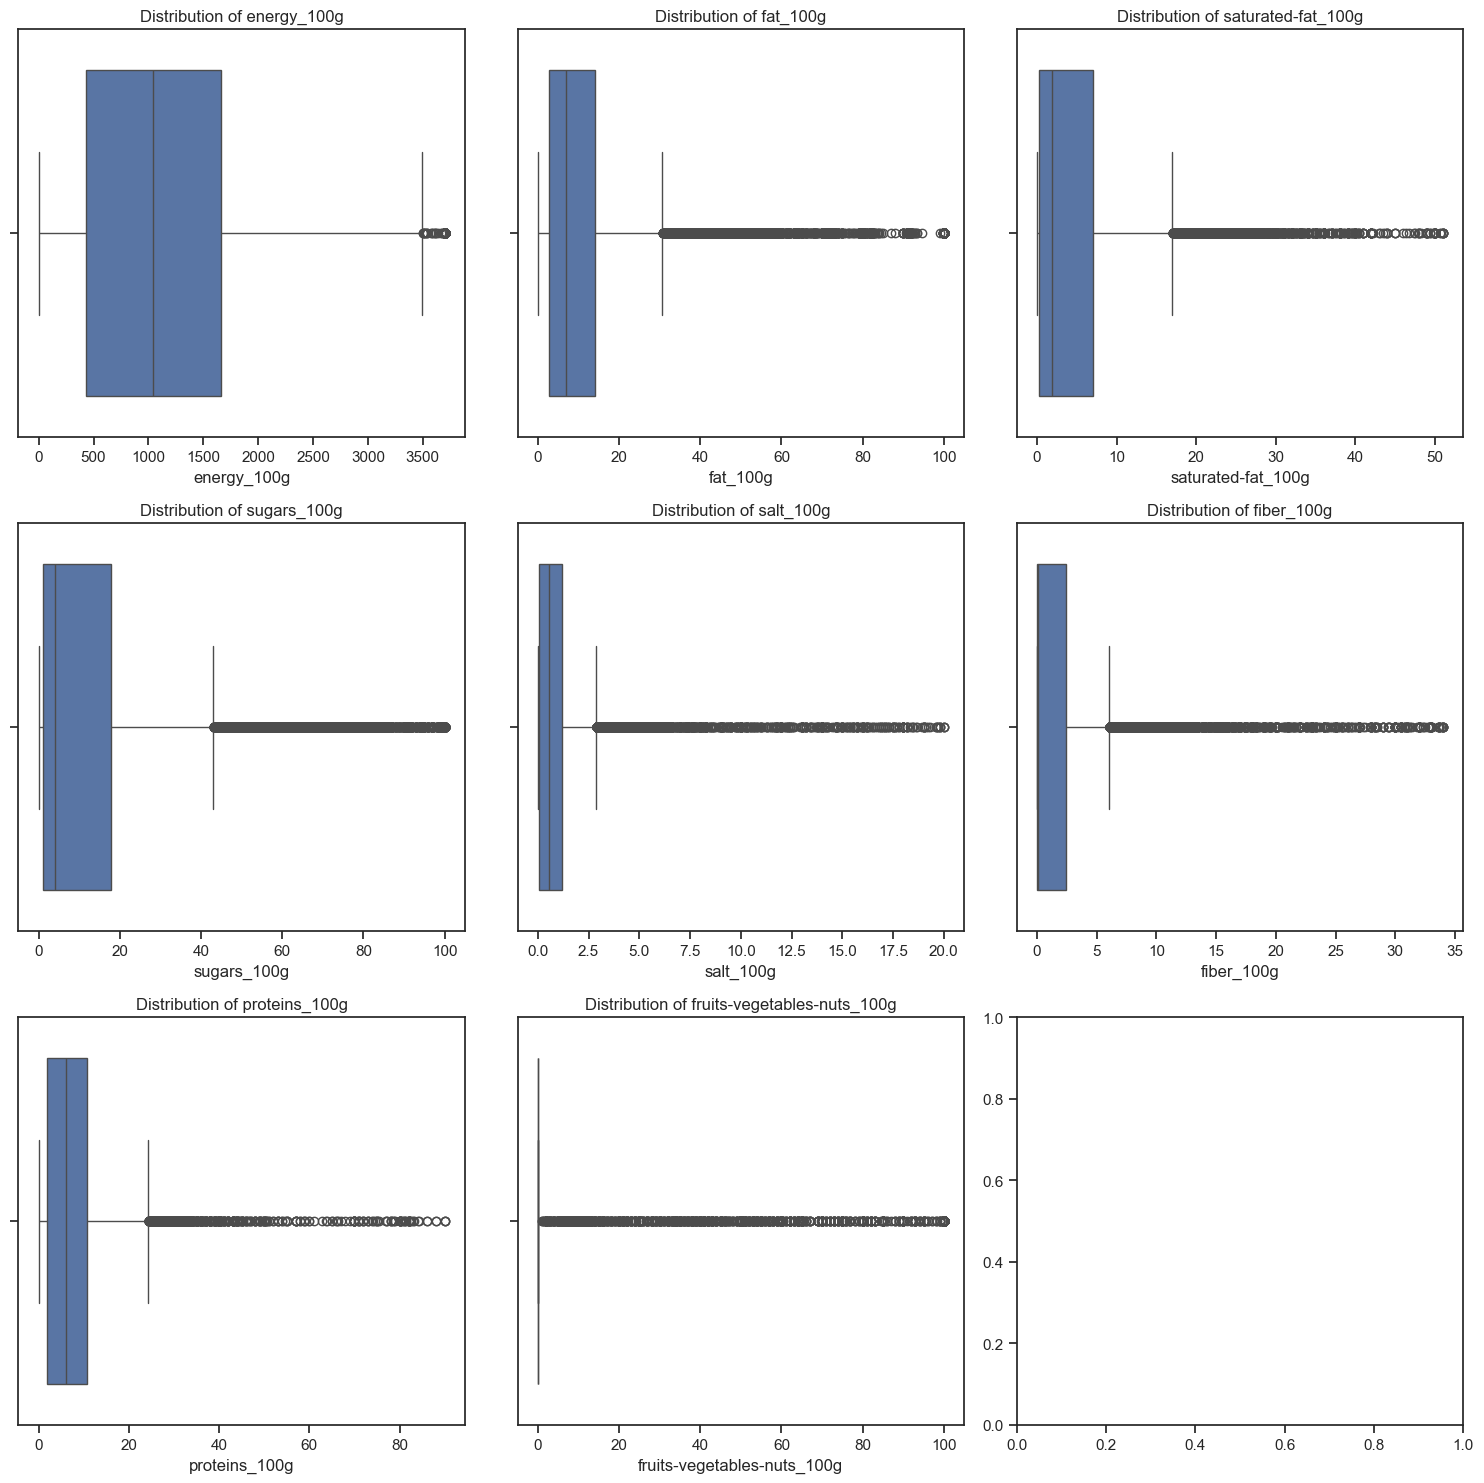

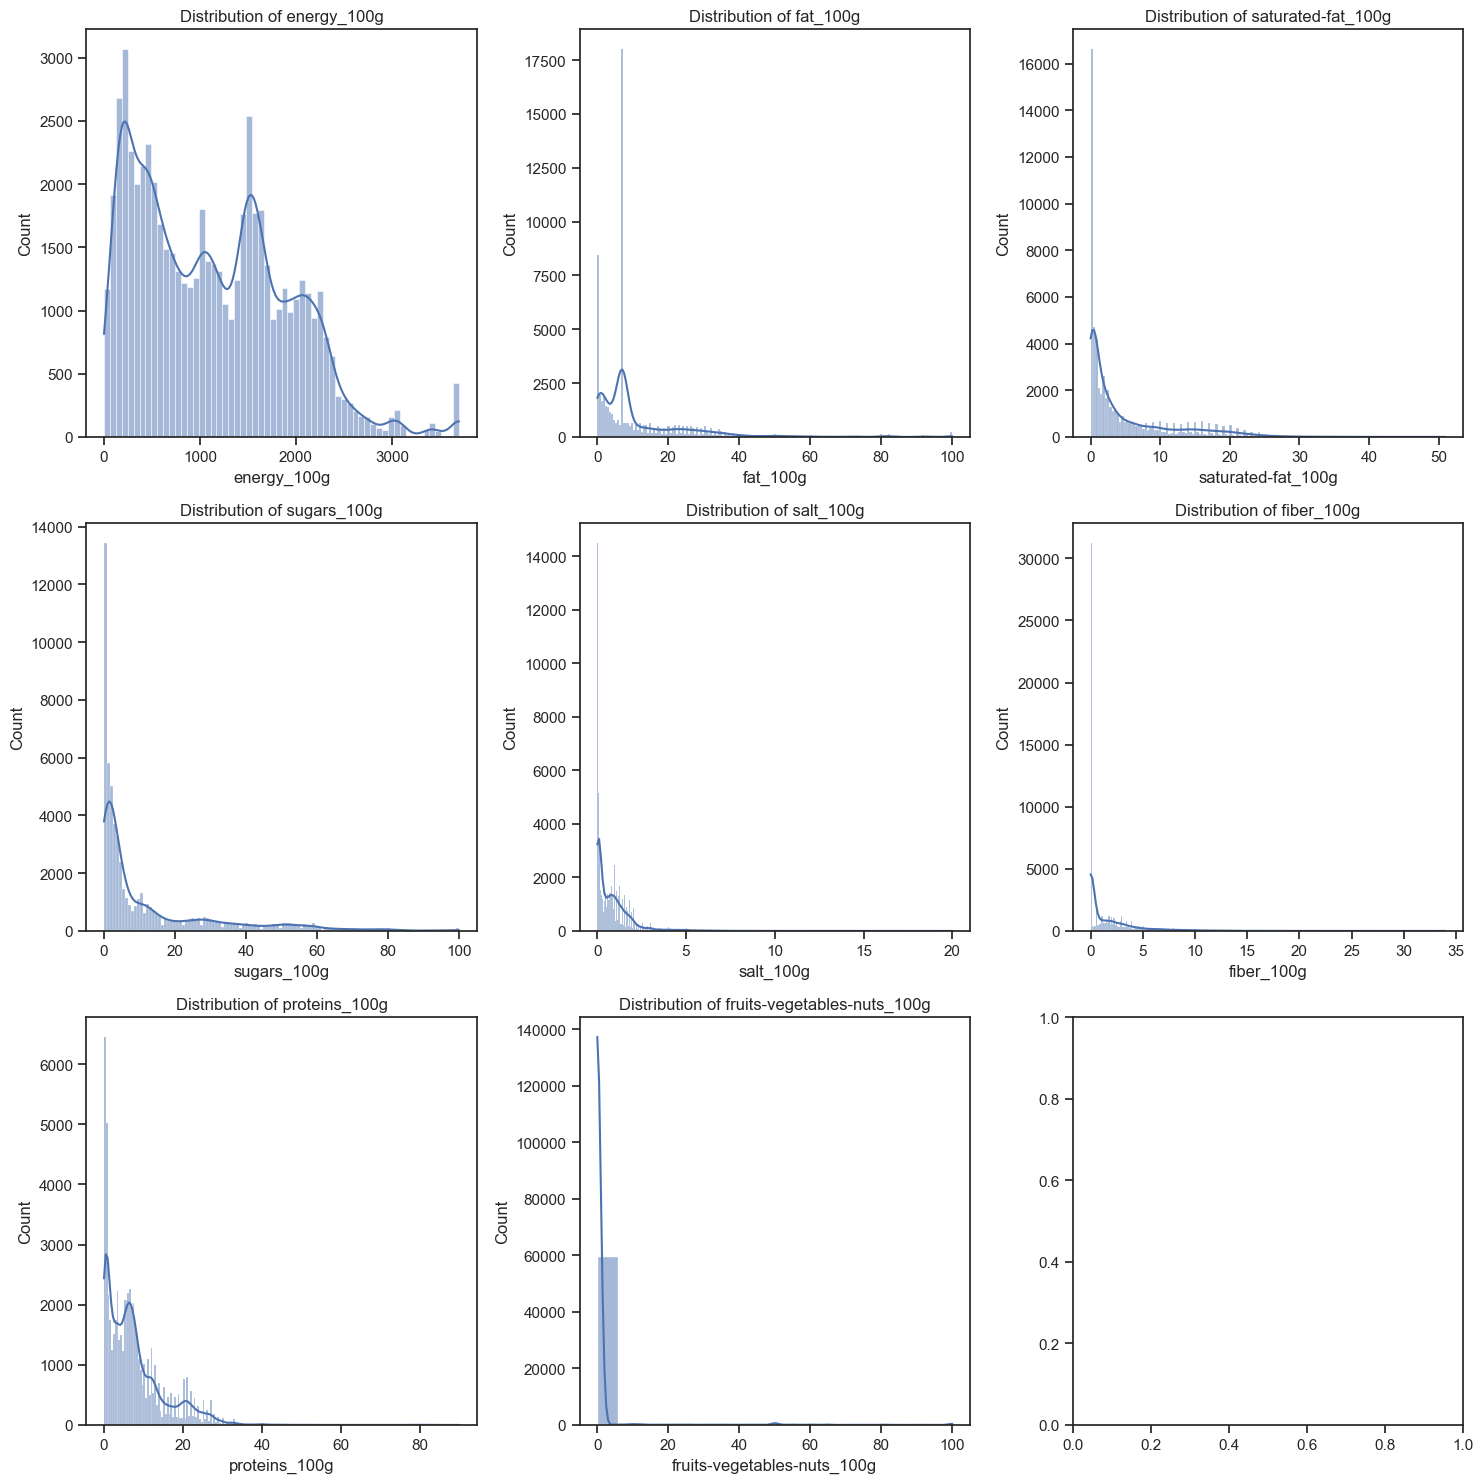

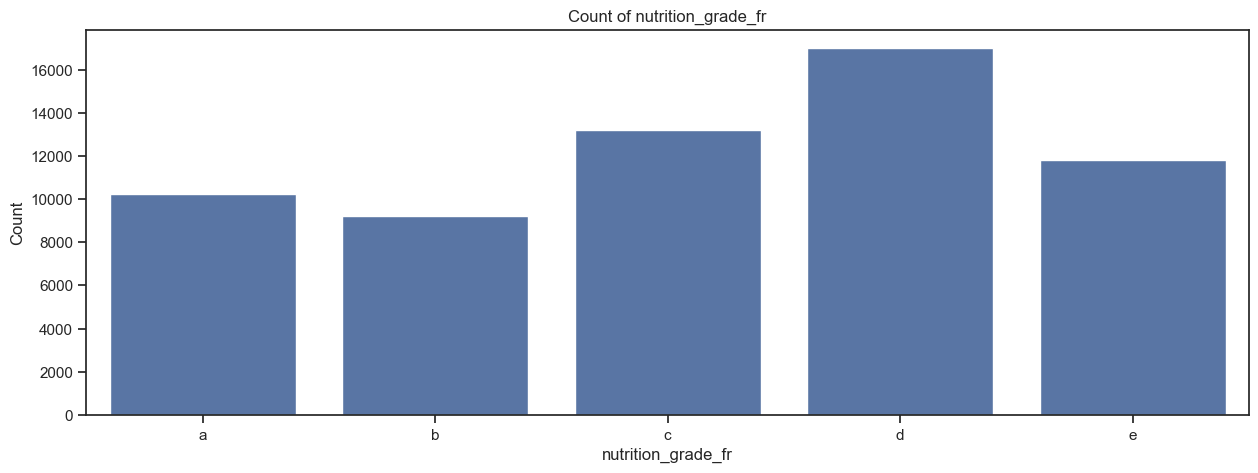

nutrition_grade_fr
d   0.28
c   0.21
e   0.19
a   0.17
b   0.15
Name: proportion, dtype: float64


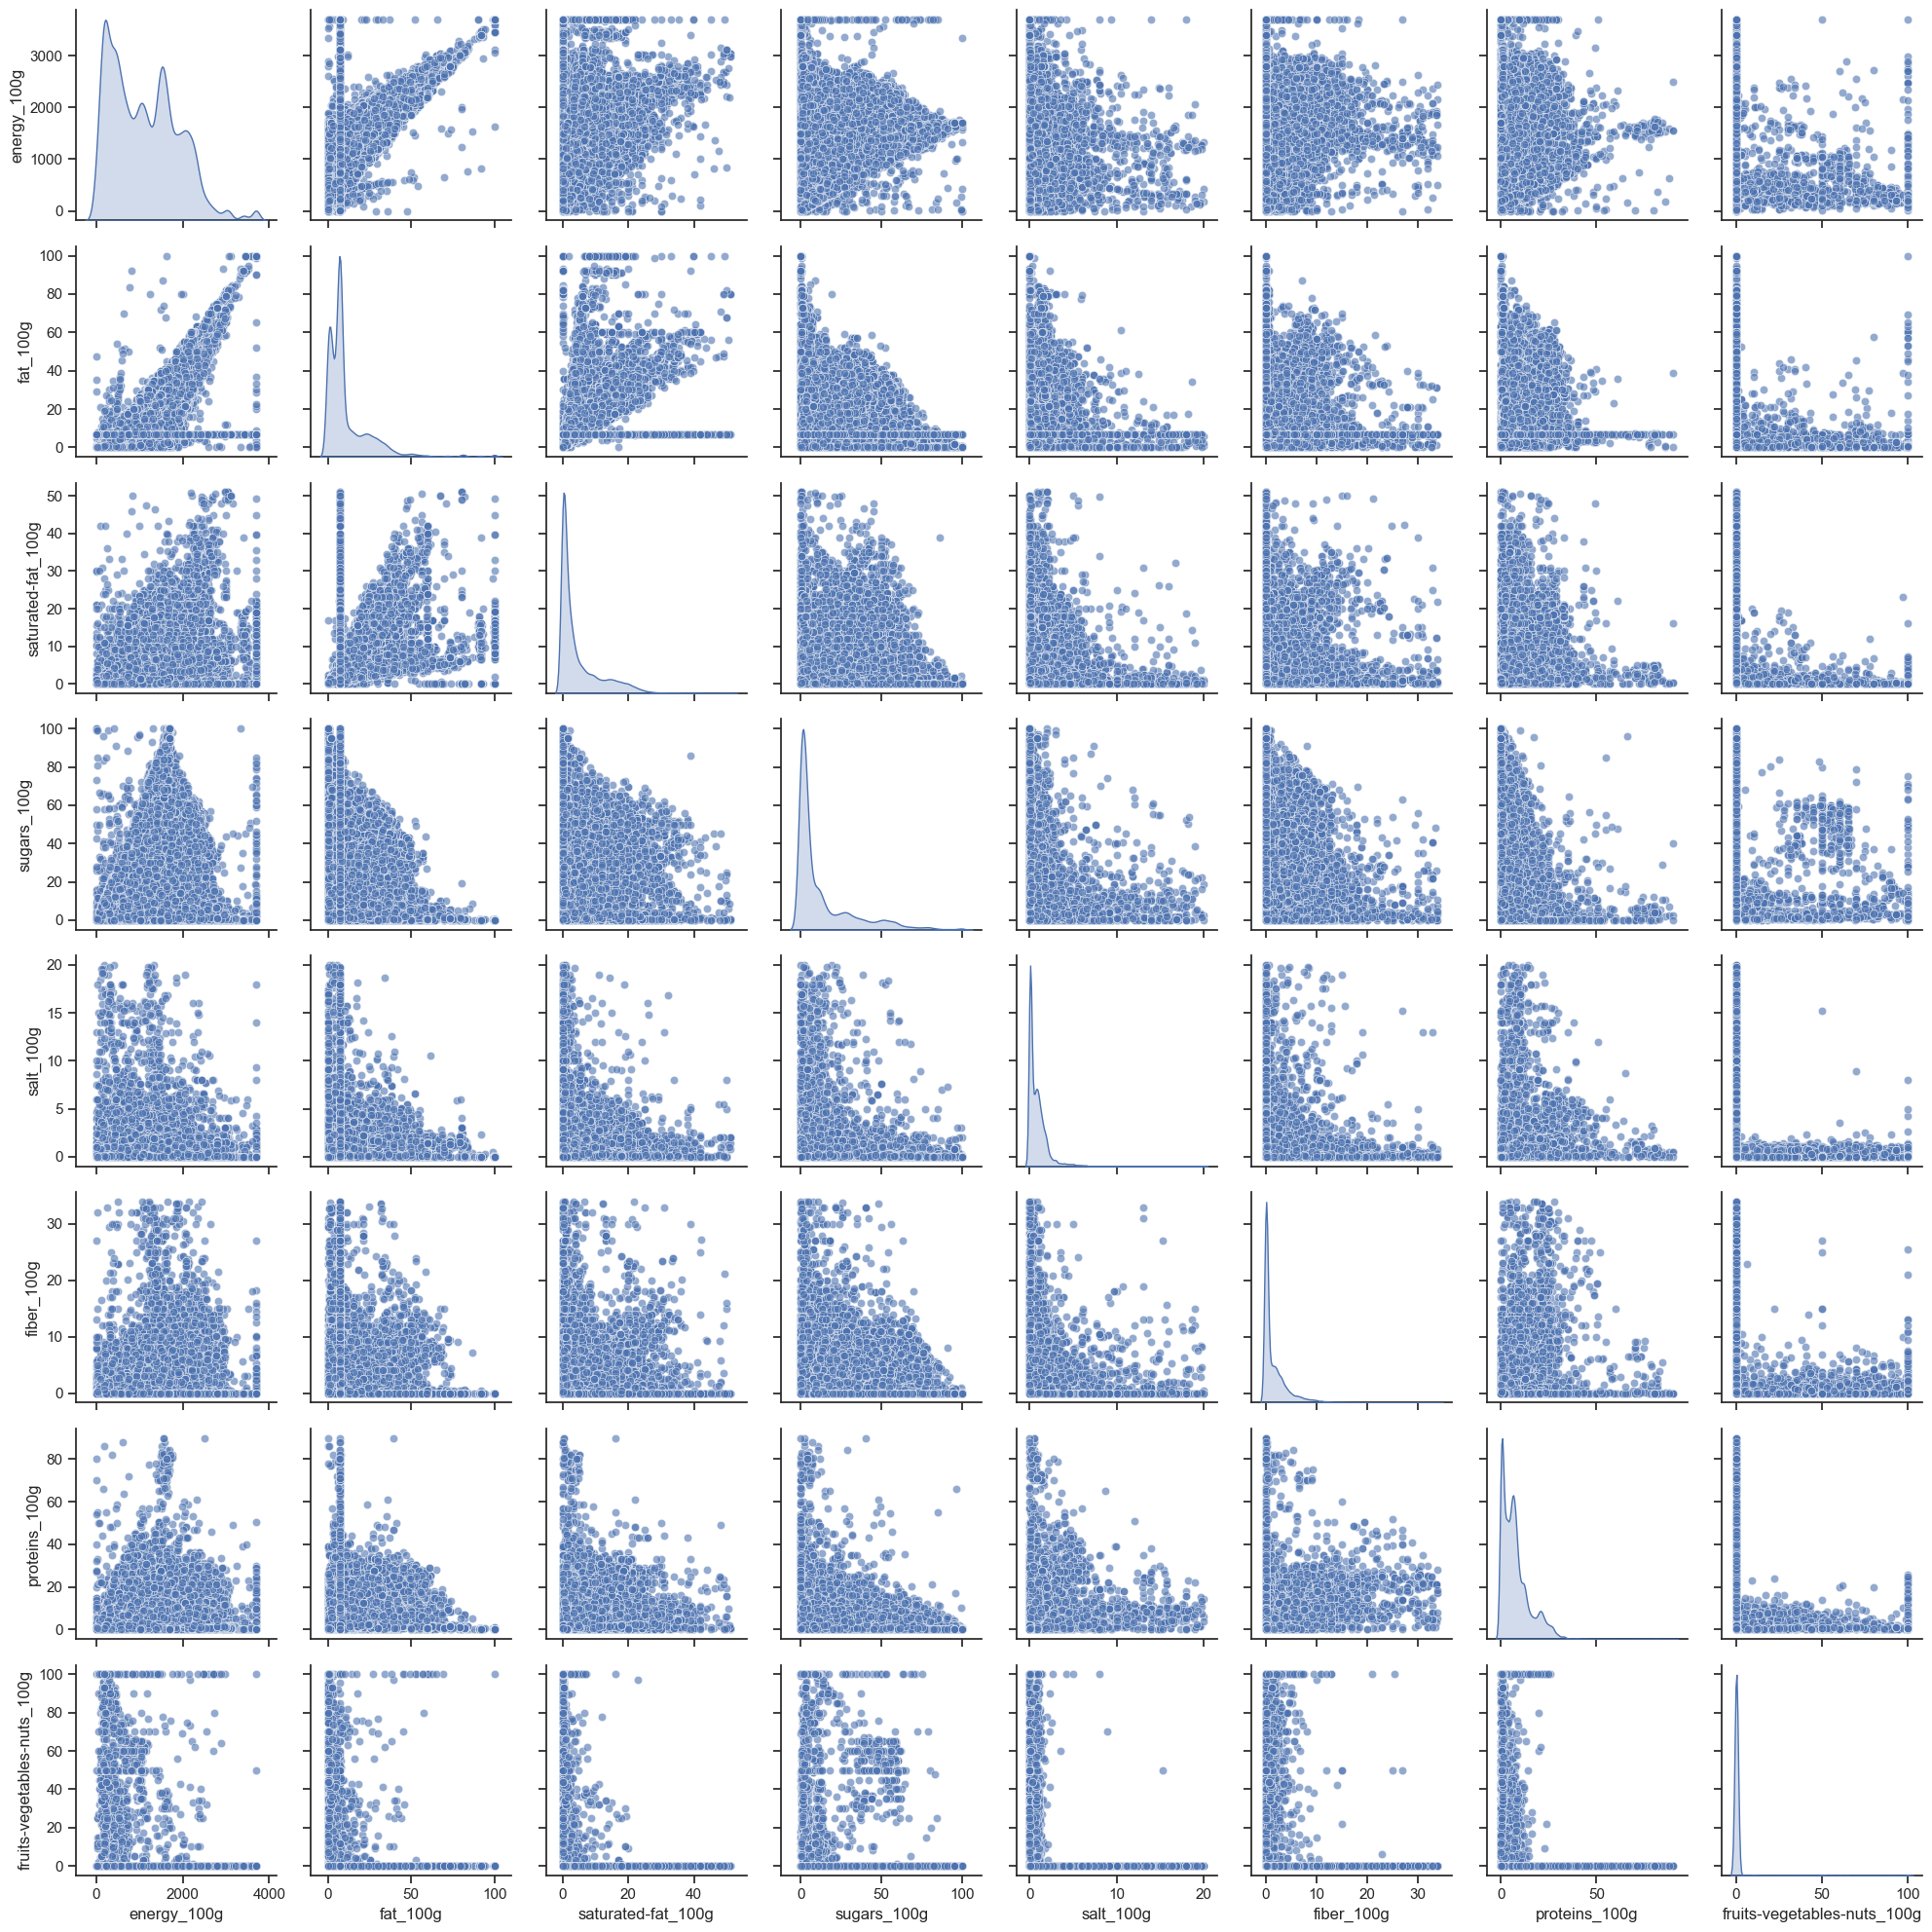

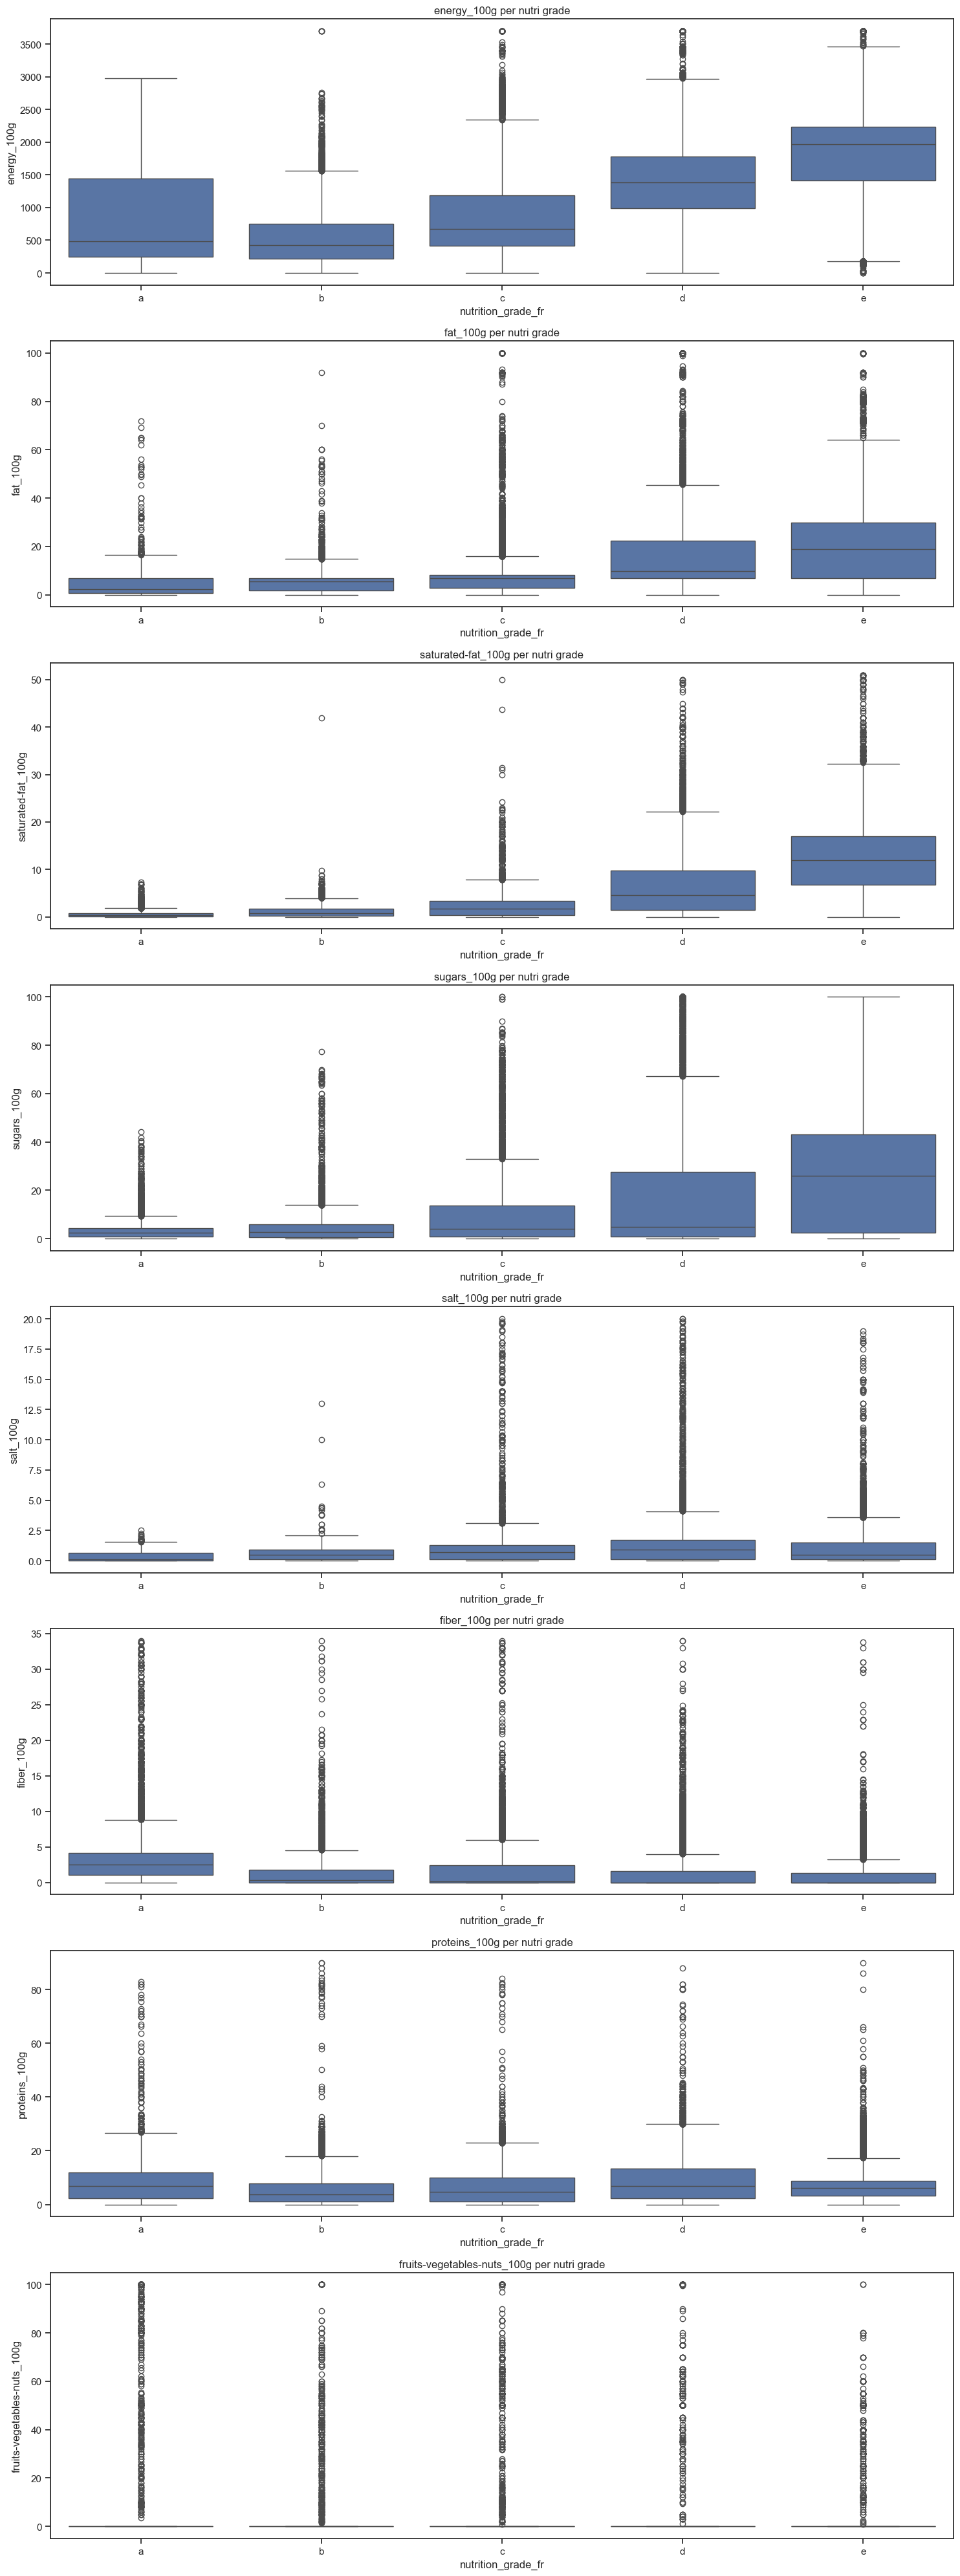

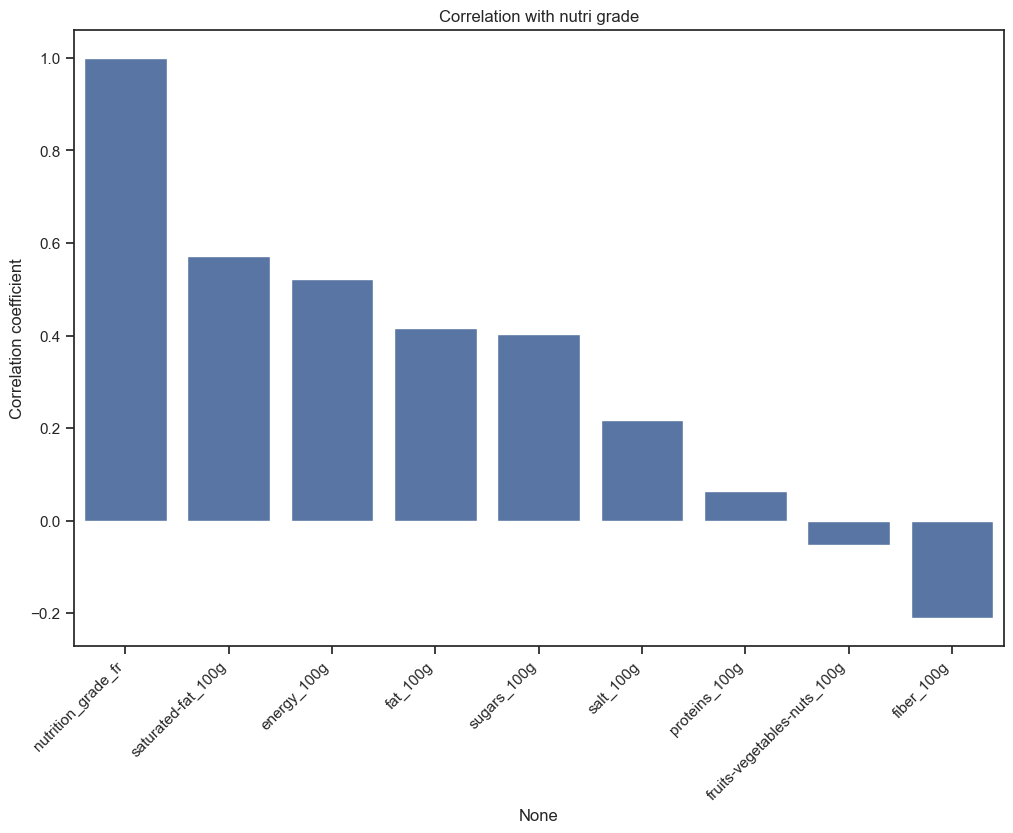

Cumulative variance ratio for 2 components: 48.03%


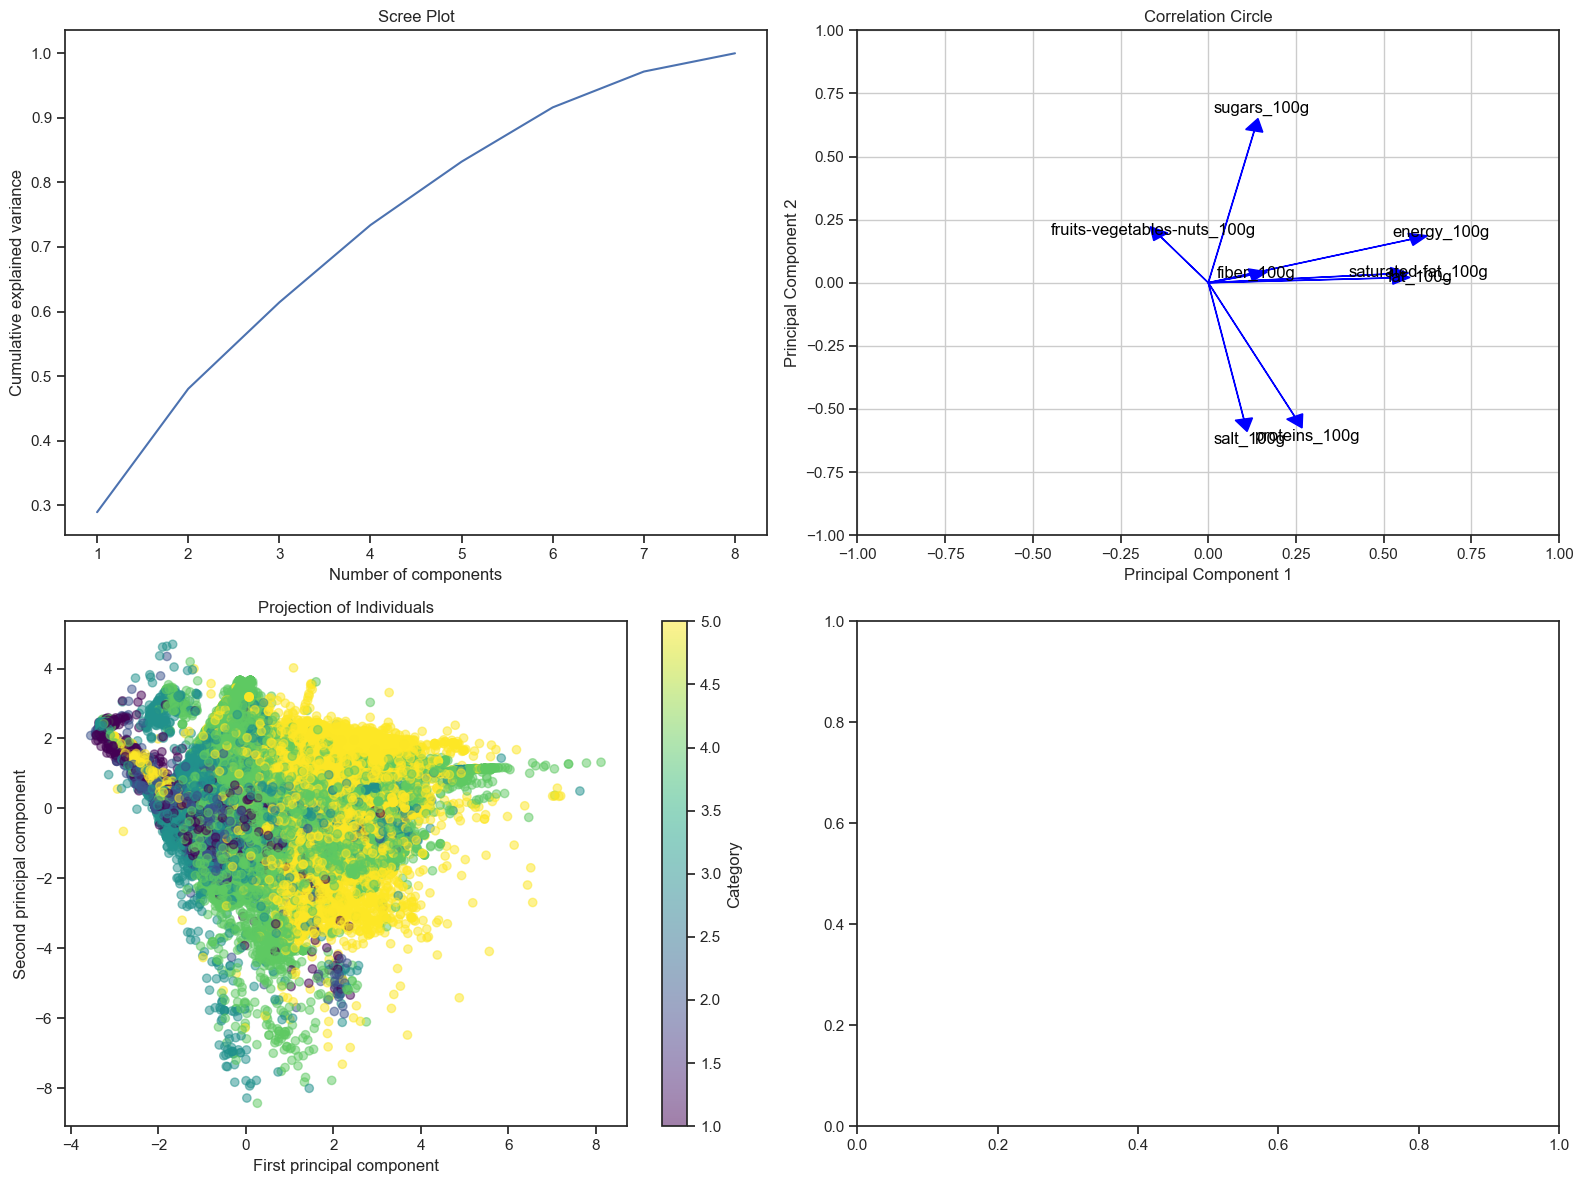

ANOVA for energy_100g:
F-value: 7249.033388951876
p-value: 0.0


ANOVA for fat_100g:
F-value: 3472.37517340154
p-value: 0.0


ANOVA for saturated-fat_100g:
F-value: 9272.599833604407
p-value: 0.0


ANOVA for sugars_100g:
F-value: 3210.4337444345247
p-value: 0.0


ANOVA for salt_100g:
F-value: 955.5246146625973
p-value: 0.0


ANOVA for fiber_100g:
F-value: 1146.1351613100896
p-value: 0.0


ANOVA for proteins_100g:
F-value: 318.60309676834214
p-value: 7.821288542996598e-272


ANOVA for fruits-vegetables-nuts_100g:
F-value: 58.40481097706327
p-value: 2.7291157253658495e-49




In [20]:
numericColumns = [col for col in numericColumns if col in data.columns]
qualitativeColumns = [col for col in qualitativeColumns if col in data.columns]
featureKeep = numericColumns + qualitativeColumns

print(f'Features : {featureKeep}')
XClean, y = prepareData(data, 'nutrition_grade_fr', subsetDup, featureKeep, 'en:france')
gradeMapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
yNumeric = y.map(gradeMapping)
print("Data frame cleaned")
print("Nb raws after clean :", len(XClean))
print("Nb features:", XClean.shape[1])

XClean = treatOutliers(XClean, outlierThresholds)
print("Outliers treated")

XImputed = imputeMissingValues(XClean)
print("Missing values imputed")
print("\nDescriptive statistics")
print(XImputed.describe())

plotBoxplots(XImputed, numericColumns)
plotHistograms(XImputed, numericColumns)
plotBarplots(XImputed, qualitativeColumns)
print(y.value_counts(normalize=True))

plotpairplots(XImputed, numericColumns)
multiBoxPlots('nutrition_grade_fr', XImputed, y, numericColumns)

corrplot(XImputed, y, numericColumns, yNumeric)
plotScaler(XImputed, numericColumns, yNumeric)
anova(XImputed, y, numericColumns)
pd.set_option('display.float_format', '{:.2f}'.format)